In [1]:
from joblib import dump, load 
import sys
import os
from tqdm import tqdm
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import sklearn, re
import pandas as pd
from collections import Counter
from sklearn.decomposition import PCA

In [129]:
def load_aggregate_matrices(direc):
    if os.path.exists(direc):
        spk_vecs = load(os.path.join(direc,'spk_vecs'))
        ph_vecs = load(os.path.join(direc,'ph_vecs'))
        spk_ph_vecs = load(os.path.join(direc,'spk_ph_vecs'))
    return spk_vecs, ph_vecs, spk_ph_vecs


def remaining_variance_ratio(vecs, pca):
    '''
    compute the amount of variance remaining in vecs
    after collapsing each of the principal components of pca
    '''
    vecs_n = np.array(vecs) - np.mean(vecs, axis=0)
    variance_left = []
    pca_vecs = PCA(n_components=min(vecs_n.shape[0],vecs_n.shape[1]))
    # print(pca_vecs)
    pca_vecs.fit(vecs)
    variance_left.append(sum(pca_vecs.explained_variance_))
    for pc in pca.components_:
        proj = np.dot(np.array(vecs_n), pc)
        collapsed_vecs = np.array(vecs_n) - np.dot(proj[:,None],pc[None,])
        pca_collapsed = PCA(n_components=min(vecs_n.shape[0],vecs_n.shape[1]))
        pca_collapsed.fit(collapsed_vecs)
        variance_left.append(sum(pca_collapsed.explained_variance_))
        vecs_n = collapsed_vecs
    pca_variance = np.concatenate([np.array([0,]),np.cumsum(pca.explained_variance_ratio_)])
    return np.array(variance_left)/variance_left[0], pca_variance

def compute_pca(direc):
    spk_vecs, ph_vecs, spk_ph_vecs = load_aggregate_matrices(direc)
    spk_pca = PCA(n_components=40)
    spk_pca.fit(spk_vecs)
    ph_pca = PCA(n_components=39)
    ph_pca.fit(ph_vecs)
    joint_pca = PCA(n_components=100)
    joint_pca.fit(spk_ph_vecs)
    return spk_pca, ph_pca, joint_pca, spk_vecs, ph_vecs, spk_ph_vecs

def phone_versus_speaker(direc):
    spk_pca, ph_pca, joint_pca, spk_vecs, ph_vecs, spk_ph_vecs = compute_pca(direc)
    return remaining_variance_ratio(ph_vecs, spk_pca)

def speaker_versus_phone(direc):
    spk_pca, ph_pca, joint_pca, spk_vecs, ph_vecs, spk_ph_vecs = compute_pca(direc)
    return remaining_variance_ratio(spk_vecs, ph_pca)

def phone_versus_joint(direc):
    spk_pca, ph_pca, joint_pca, spk_vecs, ph_vecs, spk_ph_vecs = compute_pca(direc)
    return remaining_variance_ratio(ph_vecs, joint_pca)

def speaker_versus_joint(direc):
    spk_pca, ph_pca, joint_pca, spk_vecs, ph_vecs, spk_ph_vecs = compute_pca(direc)
    return remaining_variance_ratio(spk_vecs, joint_pca)

def plot_remaining_variance(data, direc, xlabel, ylabel, plot_label):
    if xlabel == 'spk':
        collapsed_var = data.loc[direc].spk_var
        if ylabel == 'spk':
            remaining_var = 1 - data.loc[direc].spk_var
        elif ylabel == 'ph':
            remaining_var = data.loc[direc].ph_against_spk
    elif xlabel == 'ph':
        collapsed_var = data.loc[direc].ph_var
        if ylabel == 'ph':
            remaining_var = 1 - data.loc[direc].ph_var
        elif ylabel == 'spk':
            remaining_var = data.loc[direc].spk_against_ph
    # print(collapsed_var)
    plt.step(collapsed_var, remaining_var, label=plot_label)
    
def auc(x,y):
    '''
    Summarize the curve with a single number (i.e. area under curve)
    '''
    shifted = np.concatenate([[0,],x[:-1]])
    x_increment = x - shifted
    return sum(y*x_increment)

def variance_auc(data, direc, xlabel, ylabel):
    if xlabel == 'spk':
        collapsed_var = data.loc[direc].spk_var
        if ylabel == 'spk':
            remaining_var = 1 - data.loc[direc].spk_var
        elif ylabel == 'ph':
            remaining_var = data.loc[direc].ph_against_spk
    elif xlabel == 'ph':
        collapsed_var = data.loc[direc].ph_var
        if ylabel == 'ph':
            remaining_var = 1 - data.loc[direc].ph_var
        elif ylabel == 'spk':
            remaining_var = data.loc[direc].spk_against_ph
    # print(collapsed_var)
    return auc(collapsed_var, remaining_var)

def all_auc(data, direc):
    spk_ph = variance_auc(data,direc,'spk','ph')
    ph_ph = variance_auc(data,direc,'ph','ph')
    ph_spk = variance_auc(data,direc,'ph','spk')
    spk_spk = variance_auc(data,direc,'spk','spk')
    return spk_ph, ph_ph, ph_spk, spk_spk

### Sanity check: the remaining variance ratio and the explained_variance_ratio provided by sklearn should sum to 1

In [100]:
direc = 'aggregated_vectors/cpc_big/layer2'
spk_pca, ph_pca, joint_pca, spk_vecs, ph_vecs, spk_ph_vecs = compute_pca(direc)
ph_var, _ = remaining_variance_ratio(ph_vecs, ph_pca)

In [101]:
ph_var[1:] + np.cumsum(ph_pca.explained_variance_ratio_)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.])

### Comparing similarity plot against the corresponding "remaining variance" plot

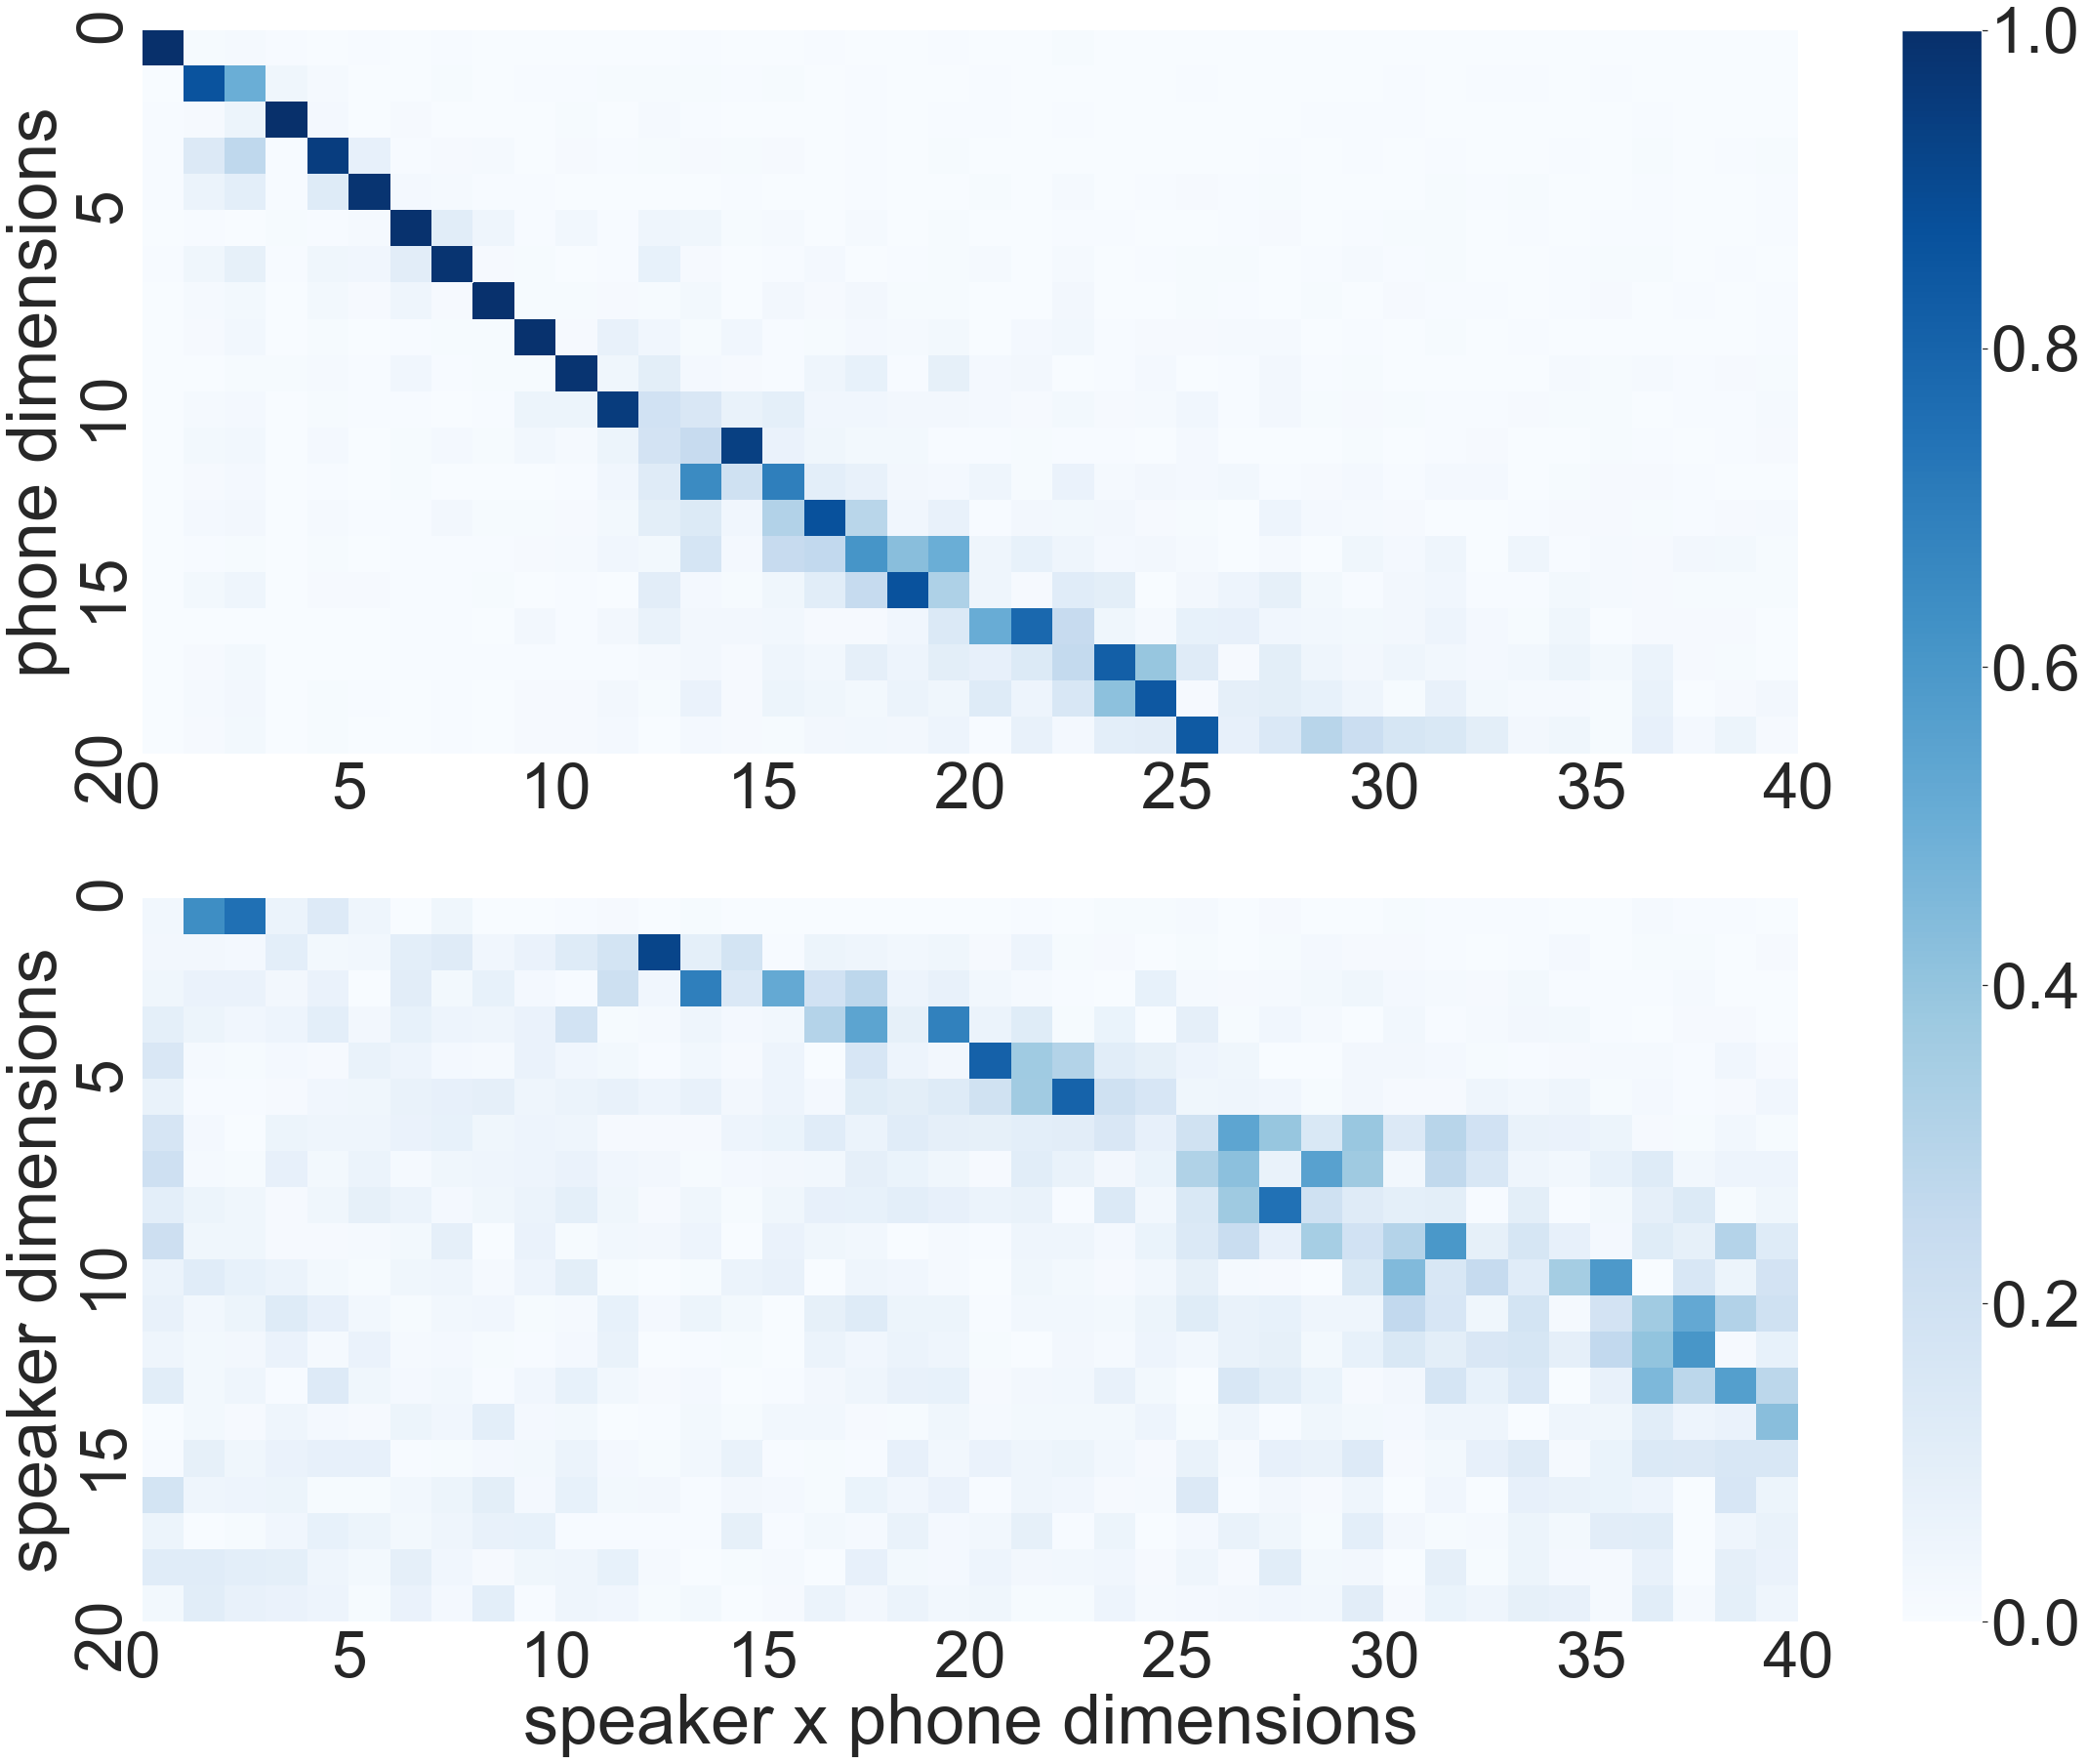

In [117]:
sm = plt.cm.ScalarMappable(cmap="Blues")
# plt.figure(figsize=(35,15))
# plt.autoscale()
sns.set(font_scale=6) 
f, axes = plt.subplots(2,1, figsize=(38,30))
s=sns.heatmap(np.abs(np.dot(ph_pca.components_[:20], joint_pca.components_[:40].transpose())),vmin=0,vmax=1, cmap='Blues',cbar=False, ax=axes[0])
s.set_ylabel('phone dimensions')
yticks = [0,5,10,15,20]
xticks = np.linspace(0,40,9).astype(int)
s.set_xticks(xticks)
s.set_yticks(yticks)
s.set_xticklabels(xticks)
s.set_yticklabels(yticks)

s=sns.heatmap(np.abs(np.dot(spk_pca.components_[:20], joint_pca.components_[:40].transpose())),vmin=0,vmax=1, cmap='Blues',cbar=False, ax=axes[1])
s.set_ylabel('speaker dimensions')
s.set_xlabel('speaker x phone dimensions')
yticks = [0,5,10,15,20]
s.set_xticks(xticks)
s.set_yticks(yticks)
s.set_xticklabels(xticks)
s.set_yticklabels(yticks)
f.colorbar(sm, ax=axes.flatten(),orientation="vertical")
# plt.tight_layout()
# plt.savefig('spk_ph_dimensions_cpc_small.pdf',dpi=300, bbox_inches='tight')
sns.set(font_scale=2) 

In [104]:
ph_var, spk_var = phone_versus_speaker(direc)

the speaker versus speaker curve gives us the baseline

0.9678331807151846 0.4456061669502012 0.6012239317068904


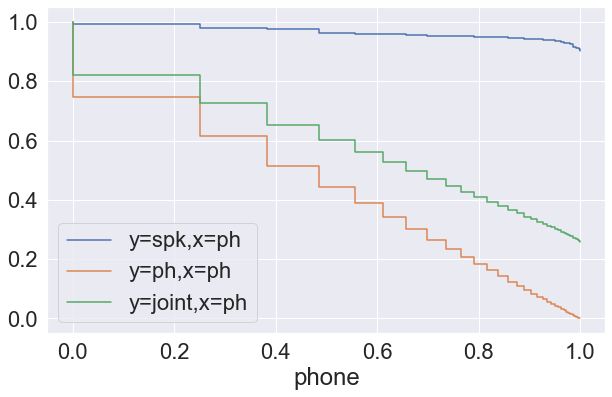

In [76]:
plt.figure(figsize=(10,6))
spk_var, ph_var = remaining_variance_ratio(spk_vecs, ph_pca)
joint_var, ph_var = remaining_variance_ratio(spk_ph_vecs, ph_pca)
plt.step(ph_var,spk_var,label='y=spk,x=ph')
plt.step(ph_var,1-ph_var,label='y=ph,x=ph')
plt.step(ph_var,joint_var,label='y=joint,x=ph')
plt.xlabel('phone')
plt.legend()
print(auc(ph_var,spk_var),auc(ph_var,1-ph_var),auc(ph_var,joint_var))

0.3976550227686708 0.9708718218863734 0.858327314023611


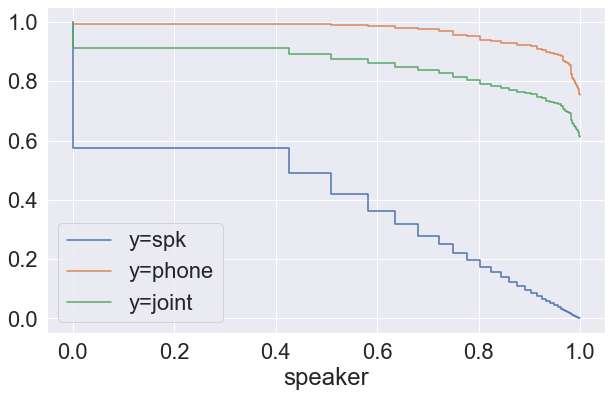

In [79]:
plt.figure(figsize=(10,6))
ph_var, spk_var = remaining_variance_ratio(ph_vecs, spk_pca)
joint_var, spk_var = remaining_variance_ratio(spk_ph_vecs, spk_pca)
plt.step(spk_var,1-spk_var,label='y=spk')
plt.step(spk_var,ph_var,label='y=phone')
plt.step(spk_var,joint_var,label='y=joint')
plt.legend()
plt.xlabel('speaker')
print(auc(spk_var,1-spk_var),auc(spk_var,ph_var),auc(spk_var,joint_var))

0.5541057809590842 0.3857577468095043 0.46744104317198776


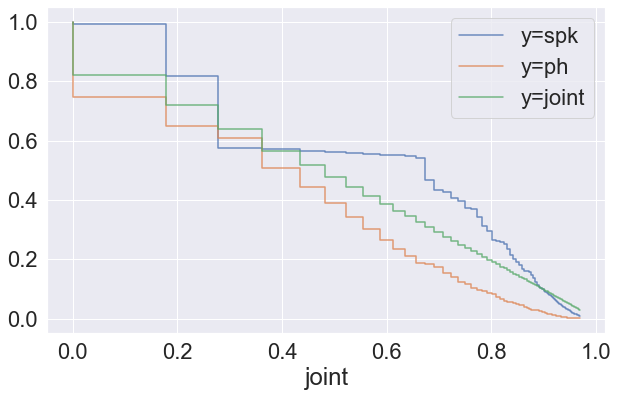

In [78]:
plt.figure(figsize=(10,6))
ph_var, joint_var = remaining_variance_ratio(ph_vecs, joint_pca)
spk_var, joint_var = remaining_variance_ratio(spk_vecs, joint_pca)

plt.step(joint_var,spk_var,alpha=0.8,label='y=spk')
plt.step(joint_var,ph_var,alpha=0.8,label='y=ph')
plt.step(joint_var,1-joint_var,alpha=0.8,label='y=joint')
plt.xlabel('joint')
plt.legend()
print(auc(joint_var,spk_var),auc(joint_var,ph_var),auc(joint_var,1-joint_var))

## Now we can start comparing between layers of CPC big

In [118]:
df = pd.DataFrame(columns=['direc', 'ph_against_spk', 'spk_against_ph', 'ph_var', 'spk_var'])

In [119]:
all_direcs = []
for root, subdirs, files in os.walk('aggregated_vectors'):
    if set(files) == set(['spk_vecs', 'ph_vecs', 'spk_ph_vecs']):
        all_direcs.append(root)

In [120]:
for direc in tqdm(all_direcs):
    spk_pca, ph_pca, joint_pca, spk_vecs, ph_vecs, spk_ph_vecs = compute_pca(direc)
    spk_against_ph, ph_var = remaining_variance_ratio(spk_vecs, ph_pca)
    ph_against_spk, spk_var = remaining_variance_ratio(ph_vecs, spk_pca)
    # df.loc[len(layers)] = [direc, list(ph_against_spk), list(spk_against_ph), list(ph_var), list(spk_var)]
    loc = len(df)
    df.loc[loc] = [direc,None,None,None,None]
    df.loc[loc].ph_against_spk = ph_against_spk
    df.loc[loc].spk_against_ph = spk_against_ph
    df.loc[loc].ph_var = ph_var
    df.loc[loc].spk_var = spk_var
df = df.set_index('direc')

100%|██████████| 18/18 [00:02<00:00,  6.69it/s]


In [122]:
spk_ph_auc = []
ph_spk_auc = []
spk_spk_auc = []
ph_ph_auc = []

for direc in df.index.values:
    spk_ph, ph_ph, ph_spk, spk_spk = all_auc(df, direc)
    spk_ph_auc.append(spk_ph)
    ph_spk_auc.append(ph_spk)
    spk_spk_auc.append(spk_spk)
    ph_ph_auc.append(ph_ph)
    
df['spk_ph_auc']=spk_ph_auc
df['ph_ph_auc']=ph_ph_auc
df['spk_spk_auc']=spk_spk_auc
df['ph_spk_auc']=ph_spk_auc

## Comparing between layers

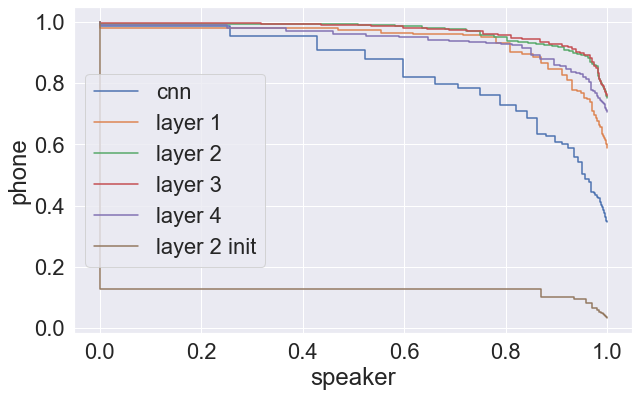

In [88]:
plt.figure(figsize=(10,6))
plot_remaining_variance(df, 'aggregated_vectors/cpc_big/cnn', 'spk','ph','cnn')
plot_remaining_variance(df, 'aggregated_vectors/cpc_big/layer1', 'spk','ph','layer 1')
plot_remaining_variance(df, 'aggregated_vectors/cpc_big/layer2', 'spk','ph','layer 2')
plot_remaining_variance(df, 'aggregated_vectors/cpc_big/layer3', 'spk','ph','layer 3')
plot_remaining_variance(df, 'aggregated_vectors/cpc_big/layer4', 'spk','ph','layer 4')
plot_remaining_variance(df, 'aggregated_vectors/cpc_big/layer2_init', 'spk','ph','layer 2 init')
plt.xlabel('speaker')
plt.ylabel('phone')
# plt.xlim([-0.05,1.05])
plt.legend()

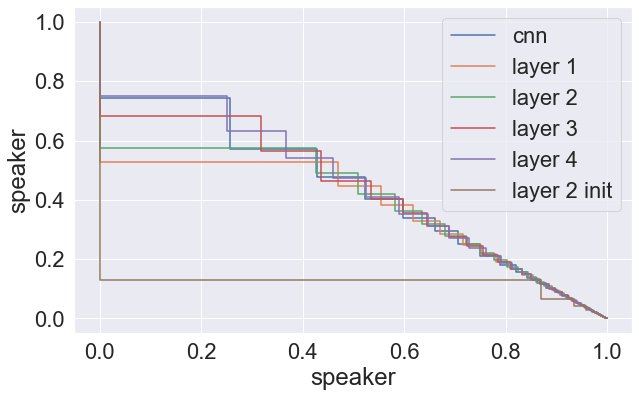

In [89]:
plt.figure(figsize=(10,6))

plot_remaining_variance(df, 'aggregated_vectors/cpc_big/cnn', 'spk','spk','cnn')
plot_remaining_variance(df, 'aggregated_vectors/cpc_big/layer1', 'spk','spk','layer 1')
plot_remaining_variance(df, 'aggregated_vectors/cpc_big/layer2', 'spk','spk','layer 2')
plot_remaining_variance(df, 'aggregated_vectors/cpc_big/layer3', 'spk','spk','layer 3')
plot_remaining_variance(df, 'aggregated_vectors/cpc_big/layer4', 'spk','spk','layer 4')
plot_remaining_variance(df, 'aggregated_vectors/cpc_big/layer2_init', 'spk','spk','layer 2 init')
plt.xlabel('speaker')
plt.ylabel('speaker')
# plt.xlim([-0.05,1.05])
plt.legend()

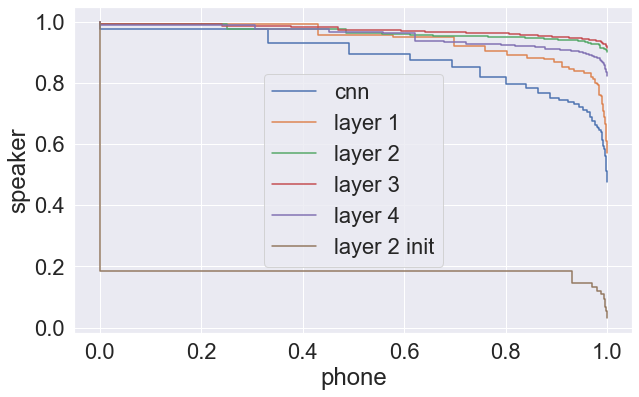

In [90]:
plt.figure(figsize=(10,6))
plot_remaining_variance(df, 'aggregated_vectors/cpc_big/cnn', 'ph','spk','cnn')
plot_remaining_variance(df, 'aggregated_vectors/cpc_big/layer1', 'ph','spk','layer 1')
plot_remaining_variance(df, 'aggregated_vectors/cpc_big/layer2', 'ph','spk','layer 2')
plot_remaining_variance(df, 'aggregated_vectors/cpc_big/layer3', 'ph','spk','layer 3')
plot_remaining_variance(df, 'aggregated_vectors/cpc_big/layer4', 'ph','spk','layer 4')
plot_remaining_variance(df, 'aggregated_vectors/cpc_big/layer2_init', 'ph','spk','layer 2 init')
plt.xlabel('phone')
plt.ylabel('speaker')
# plt.xlim([-0.05,1.05])
plt.legend()

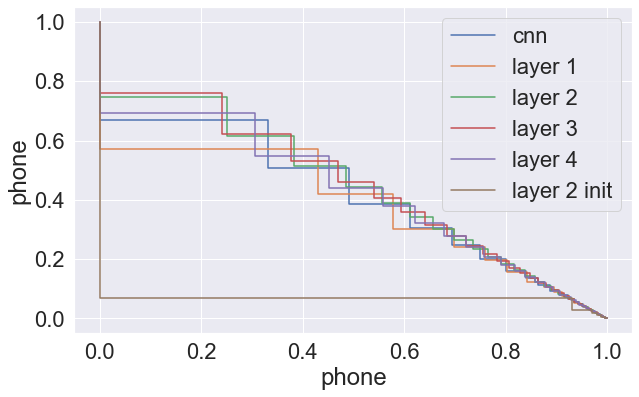

In [91]:
plt.figure(figsize=(10,6))
plot_remaining_variance(df, 'aggregated_vectors/cpc_big/cnn', 'ph','ph','cnn')
plot_remaining_variance(df, 'aggregated_vectors/cpc_big/layer1', 'ph','ph','layer 1')
plot_remaining_variance(df, 'aggregated_vectors/cpc_big/layer2', 'ph','ph','layer 2')
plot_remaining_variance(df, 'aggregated_vectors/cpc_big/layer3', 'ph','ph','layer 3')
plot_remaining_variance(df, 'aggregated_vectors/cpc_big/layer4', 'ph','ph','layer 4')
plot_remaining_variance(df, 'aggregated_vectors/cpc_big/layer2_init', 'ph','ph','layer 2 init')
plt.xlabel('phone')
plt.ylabel('phone')
# plt.xlim([-0.05,1.05])
plt.legend()

## Comparing between different models

In [107]:
ph_var_cb, spk_var_cb = phone_versus_speaker('aggregated_vectors/cpc_big/layer2')
ph_var_cs, spk_var_cs = phone_versus_speaker('aggregated_vectors/cpc_small/layer2')
ph_var_apc, spk_var_apc = phone_versus_speaker('aggregated_vectors/apc/epoch19')
# spk_pca, ph_pca, joint_pca = compute_pca('aggregated_vectors/apc/epoch19')
# ph_var_apc, spk_var_apc = remaining_variance_ratio(ph_vecs, spk_pca)

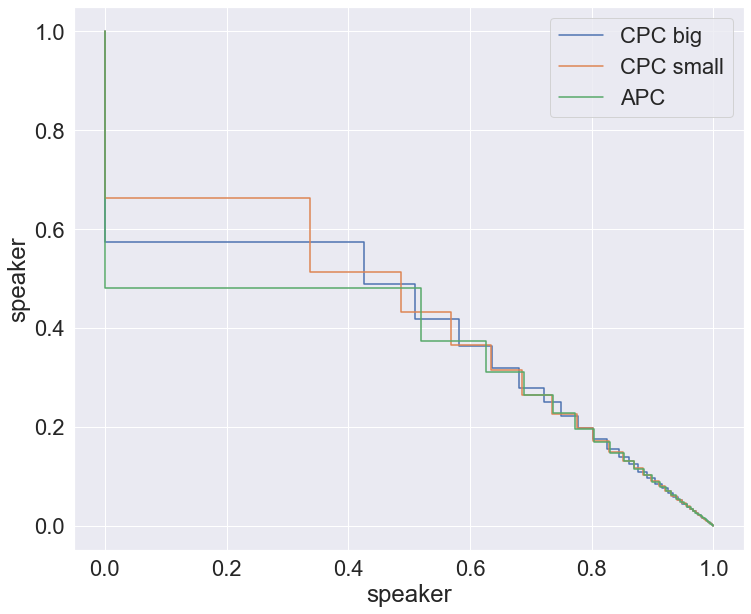

In [116]:
plt.figure(figsize=(12,10))

plot_remaining_variance(df, 'aggregated_vectors/cpc_big/layer2', 'spk','spk','CPC big')
plot_remaining_variance(df, 'aggregated_vectors/cpc_small/layer2', 'spk','spk','CPC small')
plot_remaining_variance(df, 'aggregated_vectors/apc/epoch19', 'spk','spk','APC')

plt.xlabel('speaker')
plt.ylabel('speaker')
# plt.xlim([-0.05,1.05])
plt.legend()

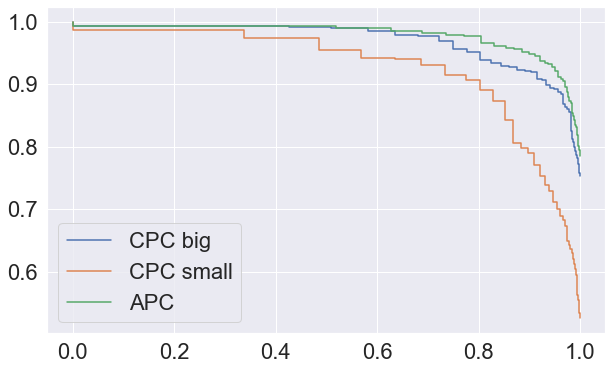

In [93]:
plt.figure(figsize=(10,6))
plt.step(spk_var_cb,ph_var_cb,label='CPC big')
plt.step(spk_var_cs,ph_var_cs,label='CPC small')
plt.step(spk_var_apc,ph_var_apc,label='APC')
plt.legend()

## Comparing between epochs of APC

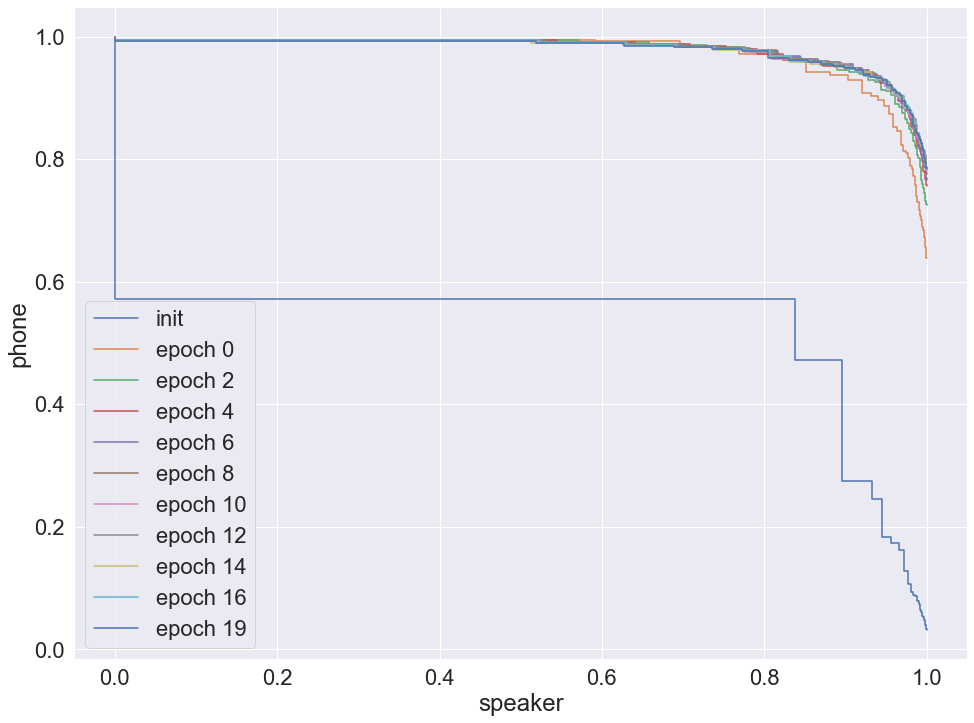

In [110]:
plt.figure(figsize=(16,12))
plot_remaining_variance(df, 'aggregated_vectors/apc/init', 'spk','ph','init')
plot_remaining_variance(df, 'aggregated_vectors/apc/epoch0', 'spk','ph','epoch 0')
plot_remaining_variance(df, 'aggregated_vectors/apc/epoch2', 'spk','ph','epoch 2')
plot_remaining_variance(df, 'aggregated_vectors/apc/epoch4', 'spk','ph','epoch 4')
plot_remaining_variance(df, 'aggregated_vectors/apc/epoch6', 'spk','ph','epoch 6')
plot_remaining_variance(df, 'aggregated_vectors/apc/epoch8', 'spk','ph','epoch 8')
plot_remaining_variance(df, 'aggregated_vectors/apc/epoch10', 'spk','ph','epoch 10')
plot_remaining_variance(df, 'aggregated_vectors/apc/epoch12', 'spk','ph','epoch 12')
plot_remaining_variance(df, 'aggregated_vectors/apc/epoch14', 'spk','ph','epoch 14')
plot_remaining_variance(df, 'aggregated_vectors/apc/epoch16', 'spk','ph','epoch 16')
plot_remaining_variance(df, 'aggregated_vectors/apc/epoch19', 'spk','ph','epoch 19')
plt.xlabel('speaker')
plt.ylabel('phone')
# plt.xlim([-0.05,1.05])
plt.legend()

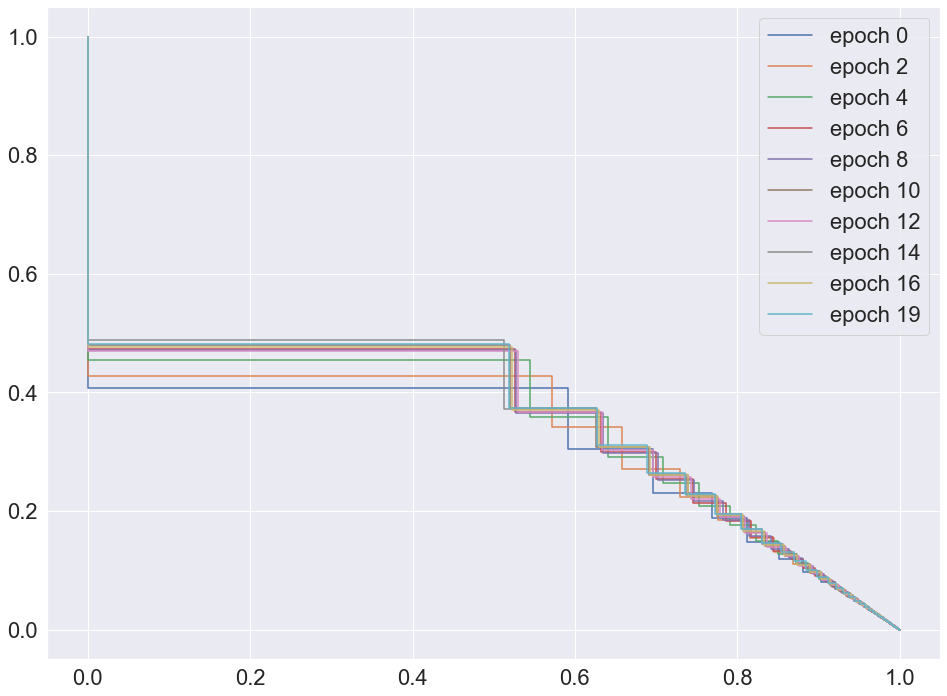

In [99]:
plt.figure(figsize=(16,12))
for i, e in enumerate(epochs):
    plt.step(spk_var_epochs[i],1-spk_var_epochs[i],label='epoch %s'%str(e))
plt.legend()

## Symmetry between phone_vs_speaker and speaker_vs_phone?

In [128]:
apc_epochs = ['aggregated_vectors/apc/epoch19', 'aggregated_vectors/apc/epoch16',
       'aggregated_vectors/apc/epoch14', 'aggregated_vectors/apc/epoch12',
       'aggregated_vectors/apc/epoch10', 'aggregated_vectors/apc/epoch8',
       'aggregated_vectors/apc/epoch6', 'aggregated_vectors/apc/epoch4',
       'aggregated_vectors/apc/epoch2', 'aggregated_vectors/apc/epoch0',
       'aggregated_vectors/apc/init']
cpc_layers = ['aggregated_vectors/cpc_big/cnn', 'aggregated_vectors/cpc_big/layer1',
       'aggregated_vectors/cpc_big/layer2',
       'aggregated_vectors/cpc_big/layer3',
       'aggregated_vectors/cpc_big/layer4',
       'aggregated_vectors/cpc_big/layer2_init']
from scipy.stats import kendalltau
df_subset = df[df.index.isin(cpc_layers)]
print(kendalltau(df_subset['spk_ph_auc'].values, df_subset['ph_spk_auc']))
df_subset = df[df.index.isin(apc_epochs)]
print(kendalltau(df_subset['spk_ph_auc'].values, df_subset['ph_spk_auc']))

KendalltauResult(correlation=0.9999999999999999, pvalue=0.002777777777777778)
KendalltauResult(correlation=0.7090909090909091, pvalue=0.0015912097162097162)


## If we look at the endpoints only

In [31]:
for i, e in enumerate(epochs):
    print(ph_var_epochs[i][-1])

0.63852082728817
0.725307959481913
0.7569246733788476
0.7666936037820872
0.7759822163362613
0.7813892770073602
0.7867635214976922
0.7840676903845267
0.7836549310581339
0.7850620644055132
